# Disociační křivka molekulárního vodíku - detail v oblasti minima
V tomto notebooku je ukázka výpočtu disociační křivky molekulárního vodíku, konkrétně úzké části v oblasti minima. Použit zde bude bazický soubor 6-31. Budou porovnány výsledky při použití různých mapování jak z hlediska přesnosti, tak z hlediska potřebného počtu vyhodnocení. Výpočty dále urychlíme též využitím tzv. bootstrappingu, kdy vzorkovač (BOPES) využívá optimálních variačních parametrů daného stupně volnosti jako počátečních bodů pro VQE v dalších stupních volnosti.

In [1]:
#version control
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.0', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.5.2', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.0', 'qiskit-nature': '0.4.3', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# import qiskit tools
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE

# improt qiskit nature tools
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.algorithms.pes_samplers import BOPESSampler

import warnings

warnings.simplefilter("ignore", np.RankWarning)

algorithm_globals.random_seed = 75

Jako klasický driver volíme Psi4 a jako bazický soubor STO3G.

In [3]:
#define the distance which will be regarded as a degree of freedom
distance = partial(Molecule.absolute_distance, atom_pair=(1, 0))

#define the molecule
molecule = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[distance],
)

# pass molecule to PSI4 driver with sto3g basis
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="6-31g", driver_type=ElectronicStructureDriverType.PSI4
)

Zde můžeme vidět, jak vypadá fermionový operátor v druhém kvantování:

In [4]:
#define eloctronic structure problem
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=8, number terms=528
  -1.6354187225929817 * ( +_0 -_0 )
+ -0.21531189509470797 * ( +_0 -_2 )
+ -0.4677371911218105 * ( +_1 -_1 )
+ -0.2077838530542889 * ( +_1 -_3 )
+ -0.21531189509470794 * ( +_2 -_0 )
+ -0.409726538 ...


## Jordan-Wignerovo mapování
Jako první se podíváme na Jordan-Wignerovo mapování. Qubitový Hamiltonián zde má následující tvar:

In [5]:
#Jordan-Wigner mapping
qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

2.0489637661958295 * IIIIIIII
- 0.23987258067264672 * IIIIIIIZ
+ 0.08289254060917936 * IIIIIYZY
+ 0.08289254060917936 * IIIIIXZX
- 0.4301236155125805 * IIIIIIZI
+ 0.027996362957175686 * IIIIYZYI
+ 0.027996362957175686 * IIIIXZXI
- 0.5883567403032339 * IIIIIZII
- 1.570185917182014 * IIIIZIII
- 0.23987258067264658 * IIIZIIII
+ 0.08289254060917936 * IYZYIIII
+ 0.08289254060917936 * IXZXIIII
- 0.4301236155125805 * IIZIIIII
+ 0.02799636295717571 * YZYIIIII
+ 0.02799636295717571 * XZXIIIII
- 0.588356740303234 * IZIIIIII
- 1.570185917182014 * ZIIIIIII
+ 0.09564481599814345 * IIIIIIZZ
- 0.01836480653461932 * IIIIYZYZ
- 0.01836480653461932 * IIIIXZXZ
+ 0.11185014141628051 * IIIIIZIZ
+ 0.1725765237730976 * IIIIZIIZ
- 0.014596538123107706 * IIIIIYIY
- 0.014596538123107706 * IIIIIXIX
+ 0.0161672324603783 * IIIIYXXY
+ 0.01229038975700995 * IIIIYYYY
- 0.0038768427033683134 * IIIIXXYY
- 0.0038768427033683134 * IIIIYYXX
+ 0.01229038975700995 * IIIIXXXX
+ 0.0161672324603783 * IIIIXYYX
- 0.0348351277963

V dalším definujeme úlohu a jako backend použijeme StatevectorSimulator.

In [6]:
#define quantum instance (using statevector simulator)
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance)
gsc = GroundStateEigensolver(qubit_converter, solver)

Úlohu budeme počítat v 10 ekvidistantně rozmístěných bodech pro vzdálenosti jader v rozmezí 0,73 až 0,74 Ångströmů. Ke vzorkování se použije třída BOPESSampler sloužící k vyhodnocení PES při Born-Oppenheimrově aproximaci. Bootstrapping volíme jako True.

In [7]:
# Specify degree of freedom (points of interest)
points = np.linspace(0.60, 1.3, 10) #equidistantly distributes 10 points in given range
results_full = {}  # full dictionary of results for each condition
results = {}  # dictionary of (point,energy) results for each condition

# define instance to sampler
bs = BOPESSampler(gsc, bootstrap=True, num_bootstrap=None, extrapolator=None)

# execute
res = bs.sample(es_problem, points)
results_full[f""] = res.raw_results
results[f"points_"] = res.points
results[f"energies_"] = res.energies

Pro srovnání použijeme klasické řešení:

In [8]:
#compare to classical eigensolver
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(me_gsc_numpy, bootstrap=False, num_bootstrap=None, extrapolator=None)

# execute
res_np = bs_classical.sample(es_problem, points)
results_full["np"] = res_np.raw_results
results["points_np"] = res_np.points
results["energies_np"] = res_np.energies

Energie v jednotlivých bodech z VQE při JW mapování:

In [9]:
print(results[f"energies_"])

[-1.1100294870200917, -1.1245786157324777, -1.1263705499036158, -1.120476045141796, -1.1099876828919322, -1.0968278921973647, -1.0822020044750982, -1.066869269791913, -1.0513092875915717, -1.0358248105748369]


Energie v jednotlivých bodech klasicky:

In [10]:
print(results["energies_np"])

[-1.1319534598304384, -1.148135155398231, -1.1516421784929665, -1.1476167452254822, -1.139219873377178, -1.1284342908875682, -1.1165153372165468, -1.1042619909244302, -1.092184270111894, -1.0806069027817178]


Výsledky vykreslíme v grafu:

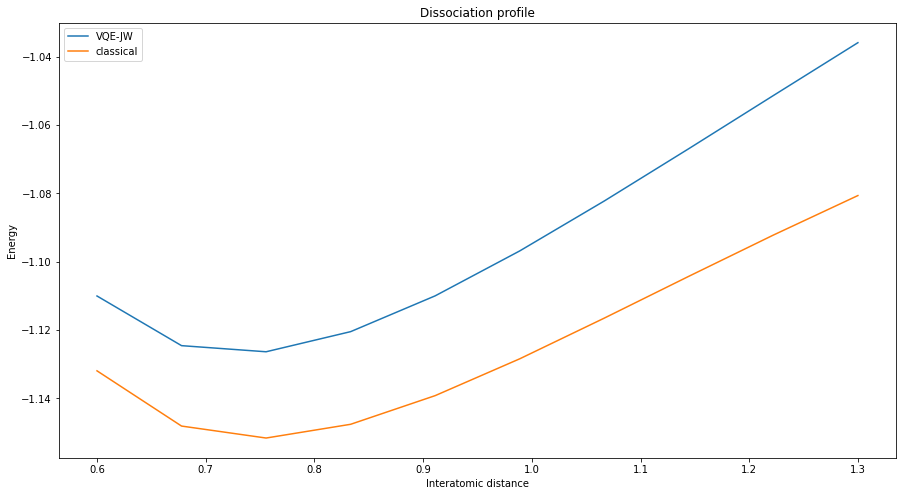

In [11]:
fig = plt.figure(figsize=(15, 8))

plt.plot(results[f"points_"], results[f"energies_"], label=f"VQE-JW")
plt.plot(results["points_np"], results["energies_np"], label="classical")
plt.legend()
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

#disable scientific notation
plt.ticklabel_format(useOffset=False, style='plain')


Vidíme, že výsledky jsou ve velmi dobré shodě. Podíváme se na nutný počet vyhodnocení:

In [12]:
for condition, result_full in results_full.items():
    if condition != "np":
        print("Total evaluations: ")
        sum = 0
        for key in result_full:
            sum += result_full[key].raw_result.cost_function_evals  
    else:
        continue
    print(sum)

Total evaluations: 
1288


Ač výsledky jsou dosti přesné, tak nutný počet vyhodnocení je, jak uvidíme dále, vyšší než u ostatních typů mapování.

## Paritní mapování bez redukce
Dále se podíváme, jak si povede paritní mapování, nebudeme-li redukovat počet qubitů. Qubitový Hamiltonián zde má tvar:

In [13]:
#Parity mapping
qubit_converter2 = QubitConverter(mapper=ParityMapper())
qubit_op2 = qubit_converter2.convert(second_q_op[0])
print(qubit_op2)

2.0489637661958295 * IIIIIIII
- 0.23987258067264672 * IIIIIIIZ
- 0.08289254060917936 * IIIIIZXX
- 0.08289254060917936 * IIIIIIYY
- 0.4301236155125805 * IIIIIIZZ
- 0.027996362957175686 * IIIIZXXZ
- 0.027996362957175686 * IIIIIYYI
- 0.5883567403032339 * IIIIIZZI
- 1.570185917182014 * IIIIZZII
- 0.23987258067264658 * IIIZZIII
- 0.08289254060917936 * IZXXZIII
- 0.08289254060917936 * IIYYIIII
- 0.4301236155125805 * IIZZIIII
- 0.02799636295717571 * ZXXZIIII
- 0.02799636295717571 * IYYIIIII
- 0.588356740303234 * IZZIIIII
- 1.570185917182014 * ZZIIIIII
+ 0.09564481599814345 * IIIIIIZI
+ 0.01836480653461932 * IIIIZXXI
+ 0.01836480653461932 * IIIIIYYZ
+ 0.11185014141628051 * IIIIIZZZ
+ 0.1725765237730976 * IIIIZZIZ
- 0.014596538123107706 * IIIIIZYY
- 0.014596538123107706 * IIIIIIXX
+ 0.0161672324603783 * IIIIZYIY
+ 0.01229038975700995 * IIIIZXIX
+ 0.0038768427033683134 * IIIIIXZX
+ 0.0038768427033683134 * IIIIZXZX
+ 0.01229038975700995 * IIIIIXIX
+ 0.0161672324603783 * IIIIIYIY
+ 0.0348351277963

In [14]:
gsc2 = GroundStateEigensolver(qubit_converter2, solver)

Třída pro vzorkování bude užívána stále stejná.

In [15]:
results_full2 = {}  # full dictionary of results for each condition
results2 = {}  # dictionary of (point,energy) results for each condition

# define instance to sampler
bs2 = BOPESSampler(gsc2, bootstrap=True, num_bootstrap=None, extrapolator=None)

# execute
res2 = bs2.sample(es_problem, points)
results_full2[f""] = res2.raw_results
results2[f"points_"] = res2.points
results2[f"energies_"] = res2.energies

Energie v jednotlivých bodech z VQE při paritním mapování bez redukce:

In [16]:
print(results2[f"energies_"])

[-0.6406543163590303, -0.706194344669461, -0.7568288062055262, -0.7972151751964294, -0.8301269689933787, -0.857309134415075, -0.8799268691188568, -0.8988176125223899, -0.9146120682192336, -0.927809082610691]


Výsledky vykreslíme v grafu:

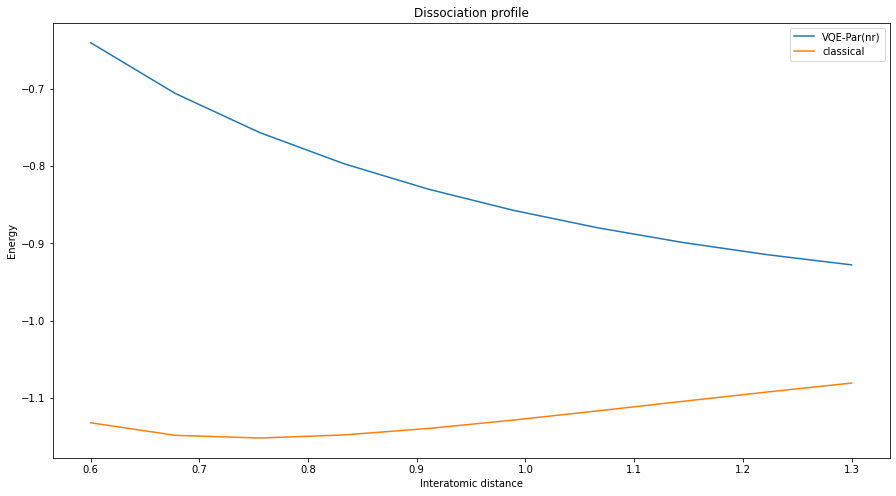

In [17]:
fig2 = plt.figure(figsize=(15, 8))

plt.plot(results2[f"points_"], results2[f"energies_"], label=f"VQE-Par(nr)")
plt.plot(results["points_np"], results["energies_np"], label="classical")
plt.legend()
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

#disable scientific notation
plt.ticklabel_format(useOffset=False, style='plain')

Vidíme, že především v minimu se výsledky přeci jen liší více než při JW mapování. Nutný počet vyhodnocení je však o něco nižší:

In [18]:
for condition, result_full2 in results_full2.items():
    if condition != "np":
        print("Total evaluations: ")
        sum2 = 0
        for key in result_full2:
            sum2 += result_full2[key].raw_result.cost_function_evals
            
    else:
        continue
    print(sum2)

Total evaluations: 
2507


## Paritní mapování s redukcí počtu qubitů
Dále se zaměříme na situaci, kdy využijeme známých symetrií, které nám při paritním mapování umožní zbavit se dvou qubitů. To by mělo mít za následek nejen snížení nutného počtu vyhodnocení, ale též větší přesnost. Qubitový operátor:

In [19]:
#Parity mapping with reduction
qubit_converter3 = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op3 = qubit_converter3.convert(second_q_op[0], num_particles=es_problem.num_particles)
print(qubit_op3)

2.0489637661958287 * IIIIII
- 0.23987258067264663 * IIIIIZ
- 0.08289254060917933 * IIIZXX
- 0.08289254060917933 * IIIIYY
- 0.4301236155125804 * IIIIZZ
+ 0.02799636295717553 * IIIXXZ
- 0.027996362957175676 * IIIYYI
- 0.5883567403032337 * IIIZZI
+ 1.5701859171820054 * IIIZII
+ 0.23987258067264522 * IIZIII
+ 0.08289254060917892 * ZXXIII
- 0.08289254060917933 * IYYIII
- 0.4301236155125804 * IZZIII
- 0.027996362957175842 * XXZIII
- 0.0279963629571757 * YYIIII
- 0.5883567403032338 * ZZIIII
- 1.5701859171820214 * ZIIIII
- 0.030208314465065465 * IIIIZI
- 0.03778572161994619 * IIIXXI
+ 0.03778572161994618 * IIIYYZ
+ 0.01502194189841724 * IIIZZZ
- 0.09633006500430422 * IIIZIZ
- 0.04943166591946216 * IIIZYY
- 0.04943166591946216 * IIIIXX
- 0.21543966888460414 * IIZIIZ
- 0.05382797363380286 * IIZZXX
- 0.05382797363380286 * IIZIYY
- 0.00950339942100169 * IZXIZX
- 0.009503399421001738 * IIXIZX
+ 0.00950339942100169 * IZXIIX
+ 0.009503399421001738 * IIXIIX
+ 0.015216350157807248 * IZXXXX
+ 0.01521635

Tentokrát musíme z dimenzionálních důvodů též nově definovat i instanci problému.

In [20]:
#define quantum instance (using statevector simulator)
quantum_instance3 = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector")) #has to be defined again
solver3 = VQE(quantum_instance=quantum_instance3) #has to be defined again due to dimension defferences
gsc3 = GroundStateEigensolver(qubit_converter3, solver3)

In [21]:
results_full3 = {}  # full dictionary of results for each condition
results3 = {}  # dictionary of (point,energy) results for each condition

# define instance to sampler
bs3 = BOPESSampler(gsc3, bootstrap=True, num_bootstrap=None, extrapolator=None)

# execute
res3 = bs3.sample(es_problem, points)
results_full3[f""] = res3.raw_results
results3[f"points_"] = res3.points
results3[f"energies_"] = res3.energies

Energie v jednotlivých bodech z VQE při paritním mapování s redukcí:

In [22]:
print(results3[f"energies_"])

[-1.122760427346484, -1.138893355388852, -1.1424689009110216, -1.138599096782328, -1.1304150556197068, -1.1198720475333286, -1.1082011477630753, -1.0961818531165526, -1.084447795654781, -1.0731126986684938]


Výsledky vykreslíme v grafu:

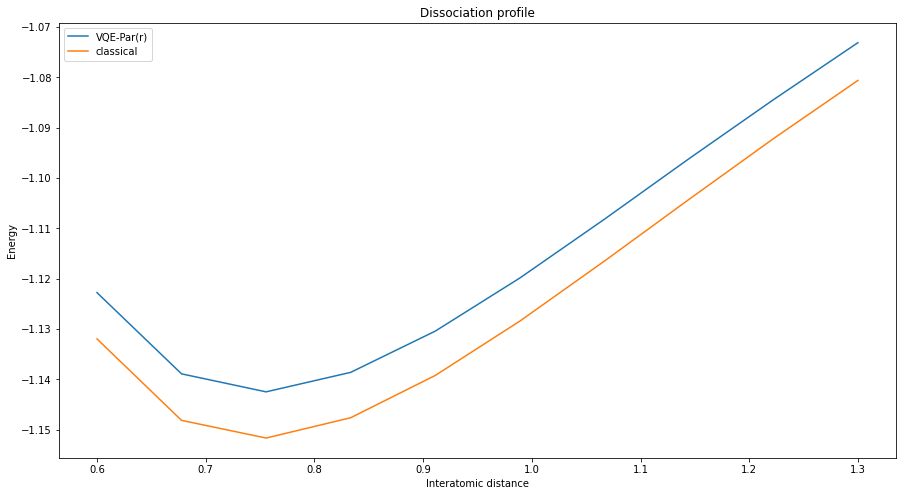

In [23]:
fig3 = plt.figure(figsize=(15, 8))

plt.plot(results3[f"points_"], results3[f"energies_"], label=f"VQE-Par(r)")
plt.plot(results["points_np"], results["energies_np"], label="classical")
plt.legend()
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

#disable scientific notation
plt.ticklabel_format(useOffset=False, style='plain')

In [24]:
for condition, result_full3 in results_full3.items():
    if condition != "np":
        print("Total evaluations: ")
        sum3 = 0
        for key in result_full3:
            sum3 += result_full3[key].raw_result.cost_function_evals
            
    else:
        continue
    print(sum3)

Total evaluations: 
2397


Vidíme, že kromě takřka dokonalé přesnosti bylo též zapotřebí zdaleka nejnižšího počtu vyhodnocení. Tato metoda je tedy v případě této molekuly preferovaná.

## Bravyi-Kitaevovo mapování
Nakonec se podíváme, jak si povede BK mapování. Qubitový operátor zde:

In [25]:
#Bravyi-Kitaev mapping
qubit_converter4 = QubitConverter(mapper=BravyiKitaevMapper())
qubit_op4 = qubit_converter4.convert(second_q_op[0])
print(qubit_op4)

2.0489637661958295 * IIIIIIII
- 0.23987258067264672 * IIIIIIIZ
+ 0.08289254060917936 * IIIIIYYX
- 0.08289254060917936 * IIIIIXYY
- 0.4301236155125805 * IIIIIIZZ
- 0.027996362957175686 * IIIIZIXZ
+ 0.027996362957175686 * IIIIIZXI
- 0.5883567403032339 * IIIIIZII
- 1.570185917182014 * IIIIZZZI
- 0.23987258067264658 * IIIZIIII
+ 0.08289254060917936 * IYYXIIII
- 0.08289254060917936 * IXYYIIII
- 0.4301236155125805 * IIZZIIII
- 0.02799636295717571 * ZIXZZIII
+ 0.02799636295717571 * IZXIIIII
- 0.588356740303234 * IZIIIIII
- 1.570185917182014 * ZZZIZIII
+ 0.09564481599814345 * IIIIIIZI
+ 0.01836480653461932 * IIIIZIXI
- 0.01836480653461932 * IIIIIZXZ
+ 0.11185014141628051 * IIIIIZIZ
+ 0.1725765237730976 * IIIIZZZZ
- 0.014596538123107706 * IIIIIYXY
- 0.014596538123107706 * IIIIIXXX
+ 0.0161672324603783 * IIIIZYZY
+ 0.01229038975700995 * IIIIZXIX
+ 0.0038768427033683134 * IIIIIXZX
+ 0.0038768427033683134 * IIIIZXZX
+ 0.01229038975700995 * IIIIIXIX
+ 0.0161672324603783 * IIIIIYZY
+ 0.0348351277963

In [26]:
gsc4 = GroundStateEigensolver(qubit_converter4, solver)

In [27]:
results_full4 = {}  # full dictionary of results for each condition
results4 = {}  # dictionary of (point,energy) results for each condition

# define instance to sampler
bs4 = BOPESSampler(gsc4, bootstrap=True, num_bootstrap=None, extrapolator=None)

# execute
res4 = bs4.sample(es_problem, points)
results_full4[f""] = res4.raw_results
results4[f"points_"] = res4.points
results4[f"energies_"] = res4.energies

Energie v jednotlivých bodech z VQE při BK mapování:

In [28]:
print(results4[f"energies_"])

[-0.6406547077146197, -0.70619452504152, -0.7568288940900771, -0.797215254608441, -0.830127581204621, -0.857308948122955, -0.87992779762808, -0.8988179629646154, -0.9146120563485414, -0.9278092980278806]


Výsledky vykreslíme v grafu:

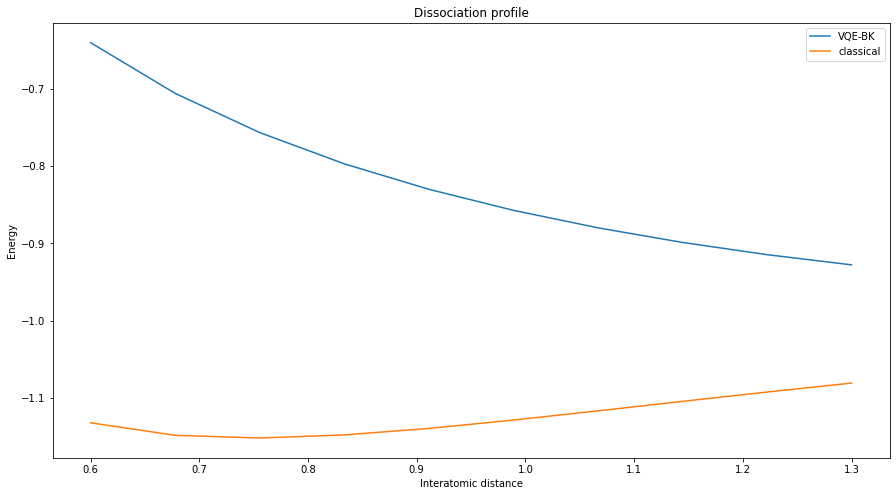

In [32]:
fig4 = plt.figure(figsize=(15, 8))

plt.plot(results4[f"points_"], results4[f"energies_"], label=f"VQE-BK")
plt.plot(results["points_np"], results["energies_np"], label="classical")
plt.legend()
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

#disable scientific notation
plt.ticklabel_format(useOffset=False, style='plain')

In [30]:
for condition, result_full4 in results_full4.items():
    if condition != "np":
        print("Total evaluations: ")
        sum4 = 0
        for key in result_full4:
            sum4 += result_full4[key].raw_result.cost_function_evals
            
    else:
        continue
    print(sum4)

Total evaluations: 
1115


Je vidět, že nepřesnost je zde ze zvolených metod zdaleka největší, ačkoli počet vyhodnocení je zde oproti JW a paritnímu mapování bez redukce nejnižší. Mimo jiné demonstruje, že ač BK mapování slibuje nejlepší asymptotické škálování co do počtu bran, tak obzvláště u menších molekul nemusí být nejlepší volbou.

In [31]:
# This code is a modification of Qiskit code licensed under the Apache License, Version 2.0.